In [1]:
import pandas as pd
import numpy as np
import git
import shutil
import time
import os
import io
import pprint
import javalang
import argparse
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
repo_path = "repos/ormlite-core"
repo = git.Repo("repos/ormlite-core")

In [3]:
path="src/test/java/com/j256/ormlite/db/BaseDatabaseTypeTest.java"
commits_touching_path = list(repo.iter_commits(paths=path))

In [4]:
commits_touching_path[0].committed_date < int(time.time())

True

In [5]:
targetfile = commits_touching_path[0].tree / path

In [6]:
with io.BytesIO(targetfile.data_stream.read()) as f:
    content = f.read().decode('utf-8')
    if "testDriverNotFound" in content:
        print(True)
    else:
        print(False)


True


In [7]:
df_all = pd.read_csv('java-maven.csv')
df_all['category'] = df_all['category'].fillna('NF')
df_clean = df_all[~df_all['category'].str.contains(';', na=False)]
df_clean = df_clean[df_clean['category'].isin(['ID','NOD', 'NF','OD','OD-Vic','OD-Brit'])]
df_clean['category'] = df_clean['category'].replace('OD-Vic','OD')
df_clean['category'] = df_clean['category'].replace('OD-Brit','OD')
df_clean['project']=df_clean['id'].str.split(':').str[0]

In [8]:
df_single = df_clean[df_clean['project']=='ormlite-core']

test_cases = []
for full_name in df_single['id']:
    test_suite = full_name.split(':')[1].rsplit('.',1)[0]
    test_case = full_name.split(':')[1].rsplit('.',1)[1]
    
    output_name = test_suite + '#' + test_case
    test_cases.append(output_name)
df_single['test_case'] = test_cases

counter = 0
for dup in df_single['test_case'].duplicated():
    if dup == True:
        counter = counter +1

df_duplicate = df_single[df_single['test_case'].isin(df_single['test_case'][df_single['test_case'].duplicated()])]
df_duplicate_NF = df_duplicate[df_duplicate['category']=='NF']
df_single = df_single.drop(df_duplicate_NF.index)

C:\Users\s222lin\AppData\Local\Temp\ipykernel_7612\3067521112.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['test_case'] = test_cases


In [9]:
def retieveTestCreationTime(row):
    
    test_file_path = "src/test/java/"+row['id'].split(':')[1].rsplit('.',1)[0].replace(".","/")+".java"
    test_name = row['id'].split(':')[1].rsplit('.',1)[1]

    repo_path = "repos/ormlite-core"
    repo = git.Repo(repo_path)

    commits_touching_path = list(repo.iter_commits(paths=test_file_path))

    creationTime = time.time()
    for commit in commits_touching_path:
        try:
            targetfile = commit.tree / test_file_path
            with io.BytesIO(targetfile.data_stream.read()) as f:
                content = f.read().decode('utf-8')
                if test_name in content and commit.committed_date < creationTime:
                    creationTime = commit.committed_date
        except KeyError:
            print('Fail retrieving commit blob:', targetfile)
    return creationTime

df_single['create_time'] = df_single.apply(retieveTestCreationTime, axis=1)

Fail retrieving commit blob: 0a9f2343e8c6774a70a8b02bd44d3fddbbe16647
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving comm

In [133]:
def create_epoch_bars(timestamps, num_bars=10):

    # Determine the range of timestamps
    min_time = timestamps.min()
    max_time = timestamps.max()

    # Create equally spaced bar edges
    bins = np.linspace(min_time, max_time, num_bars + 1)

    # Assign each timestamp to a bar based on the bin
    bars = pd.cut(timestamps, bins=bins, labels=range(1, num_bars + 1), include_lowest=True)

    return bars

In [166]:
df_single['bar'] = create_epoch_bars(df_single['create_time'])

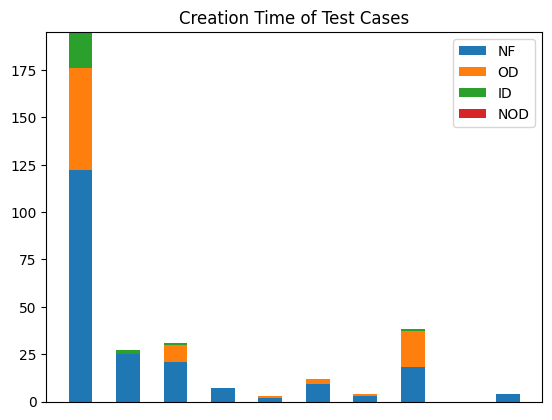

In [174]:
x = list(range(1,11))

NF_count = []
OD_count = []
ID_count = []
NOD_count = []
for i in x:
    NF_count.append(df_single[df_single['category']=='NF']['bar'].value_counts()[i])
    OD_count.append(df_single[df_single['category']=='OD']['bar'].value_counts()[i])
    ID_count.append(df_single[df_single['category']=='ID']['bar'].value_counts()[i])
    NOD_count.append(df_single[df_single['category']=='NOD']['bar'].value_counts()[i])


method_counts = {
    
    'NF': np.array(NF_count),
    'OD': np.array(OD_count),
    'ID': np.array(ID_count),
    'NOD': np.array(NOD_count)
}

width = 0.5

fig, ax = plt.subplots()

bottom = np.zeros(10)

for boolean, method_count in method_counts.items():
    p = ax.bar(x, method_count, width, label=boolean, bottom=bottom)
    bottom += method_count


ax.set_title("Creation Time of Test Cases")
ax.legend(loc="upper right")
plt.xticks([])
plt.show()

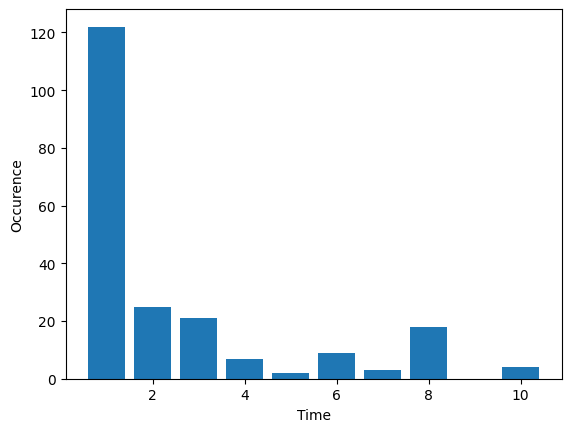

In [169]:
plt.bar(x,y)
plt.xlabel("Time")
plt.ylabel("Occurence")
plt.show()